# SPamCo with Ensembles

In [1]:
#Math packages
import numpy as np

#Data packages
import pandas as pd
from pandas_profiling import ProfileReport

#Spamco
from spamco import SPamCo, Validation

#Data packages
from sklearn.datasets import make_moons, make_classification, make_circles, make_blobs, make_gaussian_quantiles
from sklearn.datasets import load_breast_cancer, load_digits, load_iris
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

#Classifier packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb

#Validation packages
from sklearn.metrics import accuracy_score

#Visualization packages
import plotly.express as px

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
from matplotlib.ticker import MaxNLocator
%matplotlib inline

import baycomp

#General utility packages
from itertools import cycle, islice
import warnings

warnings.filterwarnings("ignore")
matplotlib.rcParams.update({'font.size': 20})

# Diabetes Health Indicators Dataset

In [2]:
df = pd.read_csv('Data/diabetes.csv')

In [3]:
y =df.values[:,0]
X =df.drop(['Diabetes_012','AnyHealthcare'], axis = 1).values

In [4]:
int(X.shape[0]/20)

12684

In [5]:
np.random.seed(1)
seeds = np.random.randint(low = 1, high = 10000, size = (10, 5))

In [6]:
label_pct = np.arange(1, 21)/2000

In [7]:
label_pct

array([0.0005, 0.001 , 0.0015, 0.002 , 0.0025, 0.003 , 0.0035, 0.004 ,
       0.0045, 0.005 , 0.0055, 0.006 , 0.0065, 0.007 , 0.0075, 0.008 ,
       0.0085, 0.009 , 0.0095, 0.01  ])

## AdaBoost

In [8]:
adaboost_base_metrics = []
adaboost_base_clfs = []

model =  {
    'classifier':AdaBoostClassifier(),
    'num_view':1,
    'gamma':0.3,
    'steps':5,
    'regularizer':'hard'
}
for i in label_pct:
    clfs, metrics = Validation.validation(
        model_params=model,
        train_data_x=X,
        train_data_y=y,
        percent_labeled=i,
        random_seed=seeds[0],
        iters=5
    )

    adaboost_base_metrics.append(metrics)
    adaboost_base_clfs.append(clfs)

adaboost_base_score = np.array(adaboost_base_metrics)

Validation Iteration: 0 Accuracy: 0.8176442762535477 Labels: 88
Validation Iteration: 0 Accuracy: 0.7260722169662567 Labels: 177
Validation Iteration: 0 Accuracy: 0.5650819930621255 Labels: 266
Validation Iteration: 0 Accuracy: 0.8122831914222642 Labels: 355
Validation Iteration: 0 Accuracy: 0.7139966361820667 Labels: 443
Validation Iteration: 0 Accuracy: 0.822190686429097 Labels: 532
Validation Iteration: 0 Accuracy: 0.8233864185850941 Labels: 621
Validation Iteration: 0 Accuracy: 0.8308630295385262 Labels: 710
Validation Iteration: 0 Accuracy: 0.8230842005676443 Labels: 799
Validation Iteration: 0 Accuracy: 0.8263428991905813 Labels: 887
Validation Iteration: 0 Accuracy: 0.8261063807421424 Labels: 976
Validation Iteration: 0 Accuracy: 0.825843582466099 Labels: 1065
Validation Iteration: 0 Accuracy: 0.8319010827288973 Labels: 1154
Validation Iteration: 0 Accuracy: 0.8335304320403658 Labels: 1243
Validation Iteration: 0 Accuracy: 0.8359744560075686 Labels: 1331
Validation Iteration: 0 

In [9]:
adaboost_multi_metrics = []
adaboost_multi_clfs = []
steps = 20
views = 2

model =  {
    'classifier':AdaBoostClassifier(),
    'num_view':views,
    'gamma':0.3,
    'steps':steps,
    'regularizer':'hard',
    'update_add_num': int(X.shape[0]/steps)
}

for i in label_pct:
    clfs, metrics = Validation.validation(
        model_params=model,
        train_data_x=X,
        train_data_y=y,
        percent_labeled=i,
        random_seed=seeds[0],
        spaco=True,
        iters=5,
        hsplit=True,
        hsplit_size=views
    )

    adaboost_multi_metrics.append(metrics)
    adaboost_multi_clfs.append(clfs)

adaboost_multi_score = np.array(adaboost_multi_metrics)

Validation Iteration: 0 Accuracy: 0.6123988226637234 Labels: 88
Validation Iteration: 0 Accuracy: 0.14490696941028067 Labels: 177
Validation Iteration: 0 Accuracy: 0.8399295700620204 Labels: 266
Validation Iteration: 0 Accuracy: 0.8424130137706297 Labels: 355
Validation Iteration: 0 Accuracy: 0.8424130137706297 Labels: 443
Validation Iteration: 0 Accuracy: 0.8424130137706297 Labels: 532
Validation Iteration: 0 Accuracy: 0.8424130137706297 Labels: 621
Validation Iteration: 0 Accuracy: 0.8424130137706297 Labels: 710
Validation Iteration: 0 Accuracy: 0.8424130137706297 Labels: 799
Validation Iteration: 0 Accuracy: 0.8424130137706297 Labels: 887
Validation Iteration: 0 Accuracy: 0.8424130137706297 Labels: 976
Validation Iteration: 0 Accuracy: 0.8424130137706297 Labels: 1065
Validation Iteration: 0 Accuracy: 0.8424130137706297 Labels: 1154
Validation Iteration: 0 Accuracy: 0.8424130137706297 Labels: 1243
Validation Iteration: 0 Accuracy: 0.8424130137706297 Labels: 1331
Validation Iteration:

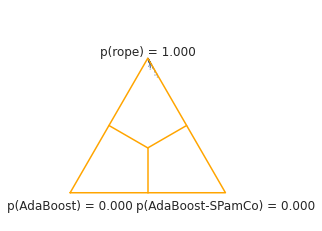

In [10]:
baycomp_ada, bayplot_ada = baycomp.two_on_multiple(
    adaboost_base_score, 
    adaboost_multi_score, 
    plot=True, 
    rope=0.05, 
    names = ('AdaBoost','AdaBoost-SPamCo'))

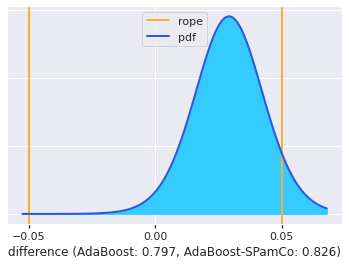

In [11]:
baycomp_ada, bayplot_ada = baycomp.two_on_single(
    np.mean(adaboost_base_score, axis=1), 
    np.mean(adaboost_multi_score, axis=1), 
    plot=True,
    rope=.05,
    names = ('AdaBoost','AdaBoost-SPamCo'))

## RandomForrestClassifier

In [12]:
rfc_base_metrics = []
rfc_base_clfs = []

model =  {
    'classifier':RandomForestClassifier(),
    'num_view':1,
    'gamma':0.3,
    'steps':5,
    'regularizer':'hard'
}

for i in label_pct:
    clfs, metrics = Validation.validation(
        model_params=model,
        train_data_x=X,
        train_data_y=y,
        percent_labeled=i,
        random_seed=seeds[0],
        iters=5
    )

    rfc_base_metrics.append(metrics)
    rfc_base_clfs.append(clfs)

rfc_base_score = np.array(rfc_base_metrics)

Validation Iteration: 0 Accuracy: 0.8355933985073057 Labels: 88
Validation Iteration: 0 Accuracy: 0.8412435614422369 Labels: 177
Validation Iteration: 0 Accuracy: 0.8425706927362556 Labels: 266
Validation Iteration: 0 Accuracy: 0.8426889519604751 Labels: 355
Validation Iteration: 0 Accuracy: 0.8414012404078629 Labels: 443
Validation Iteration: 0 Accuracy: 0.8415720592872911 Labels: 532
Validation Iteration: 0 Accuracy: 0.8407179648901503 Labels: 621
Validation Iteration: 0 Accuracy: 0.8433853673919899 Labels: 710
Validation Iteration: 0 Accuracy: 0.8428860506675077 Labels: 799
Validation Iteration: 0 Accuracy: 0.8426495322190687 Labels: 887
Validation Iteration: 0 Accuracy: 0.8440817828235047 Labels: 976
Validation Iteration: 0 Accuracy: 0.8438452643750657 Labels: 1065
Validation Iteration: 0 Accuracy: 0.8422159150635972 Labels: 1154
Validation Iteration: 0 Accuracy: 0.8433853673919899 Labels: 1243
Validation Iteration: 0 Accuracy: 0.8427152317880795 Labels: 1331
Validation Iteration: 

In [13]:
rfc_multi_metrics = []
rfc_multi_clfs = []
steps = 20
views = 2

model =  {
    'classifier':RandomForestClassifier(),
    'num_view':views,
    'gamma':0.3,
    'steps':steps,
    'regularizer':'hard',
    'update_add_num': int(X.shape[0]/steps)
}

for i in label_pct:
    clfs, metrics = Validation.validation(
        model_params=model,
        train_data_x=X,
        train_data_y=y,
        percent_labeled=i,
        random_seed=seeds[0],
        spaco=True,
        iters=5,
        hsplit=True,
        hsplit_size=views
    )

    rfc_multi_metrics.append(metrics)
    rfc_multi_clfs.append(clfs)

rfc_multi_score = np.array(rfc_multi_metrics)

NameError: name 'seed' is not defined

In [ ]:
baycomp_rfc, bayplot_rfc = baycomp.two_on_multiple(
    rfc_base_score, 
    rfc_multi_score, 
    plot=True, 
    rope=0.001, 
    names = ('RFC','RFC-SPamCo'))

## XGBoost

In [ ]:
xgboost_base_metrics = []
xgboost_base_clfs = []

model =  {
    'classifier':xgb.XGBClassifier(silent=True, verbosity=0),
    'num_view':1,
    'gamma':0.3,
    'steps':10,
    'regularizer':'hard'
}

for i in label_pct:
    clfs, metrics = Validation.validation(
        model_params=model,
        train_data_x=X,
        train_data_y=y,
        percent_labeled=i,
        random_seed=seeds[0],
        iters=5
    )

    xgboost_base_metrics.append(metrics)
    xgboost_base_clfs.append(clfs)

xgboost_base_score = np.array(xgboost_base_metrics)

In [ ]:
xgboost_multi_metrics = []
xgboost_multi_clfs = []
steps = 20
views = 2

model =  {
    'classifier':xgb.XGBClassifier(silent=True, verbosity=0),
    'num_view':views,
    'gamma':0.3,
    'steps':steps,
    'regularizer':'hard',
    'update_add_num': int(X.shape[0]/steps)
}

for i in label_pct:
    clfs, metrics = Validation.validation(
        model_params=model,
        train_data_x=X,
        train_data_y=y,
        percent_labeled=i,
        random_seed=seeds[0],
        spaco=True,
        iters=5,
        hsplit=True,
        hsplit_size=views
    )

    xgboost_multi_metrics.append(metrics)
    xgboost_multi_clfs.append(clfs)

xgboost_multi_score = np.array(xgboost_multi_metrics)

In [ ]:
baycomp_xgboost, bayplot_xgboost = baycomp.two_on_multiple(
    xgboost_base_score, 
    xgboost_multi_score, 
    plot=True, 
    rope=0.02, 
    names = ('XGBoost','XGBoost-SPamCo'))

In [ ]:
baycomp_xgboost, bayplot_xgboost = baycomp.two_on_single(
    np.mean(xgboost_base_score, axis=1), 
    np.mean(xgboost_multi_score, axis=1), 
    plot=True, 
    names = ('XGBoost','XGBoost-SPamCo'))

In [ ]:
baycomp_xgboost

In [ ]:
label_pct

In [ ]:
df = pd.DataFrame()

df['Percent of Labeled Data'] = label_pct
df['AdaBoost Mean'] =  np.mean(adaboost_base_score, axis=1)
df['AdaBoost Std'] =  np.std(adaboost_base_score, axis=1)
df['AdaBoost+SPamCo Mean'] = np.mean(adaboost_multi_score, axis=1)
df['AdaBoost+SPamCo Std'] = np.std(adaboost_multi_score, axis=1)
df['RandomForest Mean'] = np.mean(rfc_base_score, axis=1)
df['RandomForest Std'] = np.std(rfc_base_score, axis=1)
df['RandomForest+SPamCo Mean'] = np.mean(rfc_multi_score, axis=1)
df['RandomForest+SPamCo Std'] = np.std(rfc_multi_score, axis=1)
df['XGBoost Mean'] = np.mean(xgboost_base_score, axis=1)
df['XGBoost Std'] = np.std(xgboost_base_score, axis=1)
df['XGBoost+SPamCo Mean'] = np.mean(xgboost_multi_score, axis=1)
df['XGBoost+SpamCo Std'] = np.std(xgboost_multi_score, axis=1)

In [ ]:
df

In [ ]:
df.to_csv('Multiple Classifiers on Diabetes Health Data.csv')